In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import squidpy as sq
from scipy.spatial.distance import pdist, squareform
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import tabulate
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import umap
from importlib import reload
from scipy import stats

# locals
import utils as ut
reload(ut)

sc.settings.verbosity = 3
import gget

# locals
import utils as ut
reload(ut)

2022-12-13 13:20:50.515912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 13:20:50.629071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-12-13 13:20:50.629096: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 13:20:50.655078: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 13:20:52.4123

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath)
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


Pair.Name Ligand.Mouse Receptor.Mouse      Source ManualAnnotation  \
0          A2m-Lrp1          A2m           Lrp1  Ramilowski          Correct   
1       Adgre5-Cd55       Adgre5           Cd55      Baccin          Correct   
2    Adipoq-Adipor1       Adipoq        Adipor1  Ramilowski          Correct   
3    Adipoq-Adipor2       Adipoq        Adipor2  Ramilowski          Correct   
4  Adm-Calcrl&Ramp2          Adm   Calcrl&Ramp2      Baccin          Correct   

  Ligand.CC Ligand.GO     Reference (PMID / KEGG)  ligand      receptor  
0  Secreted     Other  1702392,10652313, 12194978     A2M          LRP1  
1  Membrane     Other                    23447688  ADGRE5          CD55  
2  Secreted     Other                    12802337  ADIPOQ       ADIPOR1  
3  Secreted     Other          12802337, 12802330  ADIPOQ       ADIPOR2  
4  Secreted     Other                    10342881     ADM  CALCRL&RAMP2

In [3]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


gene     scores          pvals  logfoldchanges  clusterId key  \
0  H2-EB1  36.343353  4.575346e-181        3.564091          1  ND   
1   H2-AA  35.311523  4.761517e-183        3.430534          1  ND   
2  H2-AB1  34.411163  2.815112e-177        3.234597          1  ND   
3    CD74  33.910587  2.451588e-177        3.302062          1  ND   
4  H2-DMA  31.695400  2.991793e-123        2.667091          1  ND   

      cellType  
0  Macrophages  
1  Macrophages  
2  Macrophages  
3  Macrophages  
4  Macrophages

In [4]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/"

adata = {}

for f in os.listdir(dirPath):
    
    if not f == "all":
        key = f
        mtxPath = f"{dirPath}{f}/outs/"
        data = sc.read_visium(mtxPath)
        data.var_names_make_unique()
        data.var_names = [x.upper() for x in data.var_names]
        adata[key] = data
    
adata.keys()

reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD14/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/ND/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD8/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


dict_keys(['HFD14', 'ND', 'HFD8'])

In [5]:
keys = ['ND', 'HFD8', 'HFD14']

min_counts = 10

for key in keys:
    print(key)
    data = adata[key]
    sc.pp.filter_cells(data, min_counts=min_counts)
    sc.pp.normalize_total(data, target_sum=1e4) # Normalize each cell by total counts over all genes
    sc.pp.log1p(data) # Logarithmize data via `X = \log(X + 1)`,
    sc.pp.scale(data) # unit variance and zero mean


ND
filtered out 1 cells that have less than 10 counts
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
HFD8
filtered out 2 cells that have less than 10 counts
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
HFD14
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [11]:
query = "TREM2"
queryCol = 'ligand'
# queryCol = 'receptor'

lr[lr[queryCol] == query]

Pair.Name Ligand.Mouse Receptor.Mouse      Source ManualAnnotation  \
903  Trem2-Sema6d        Trem2         Sema6d  Ramilowski       Irrelevant   

    Ligand.CC Ligand.GO Reference (PMID / KEGG) ligand receptor  
903  Membrane     Other                     NaN  TREM2   SEMA6D

ND
(2035, 31053)
0.0019656019656019656


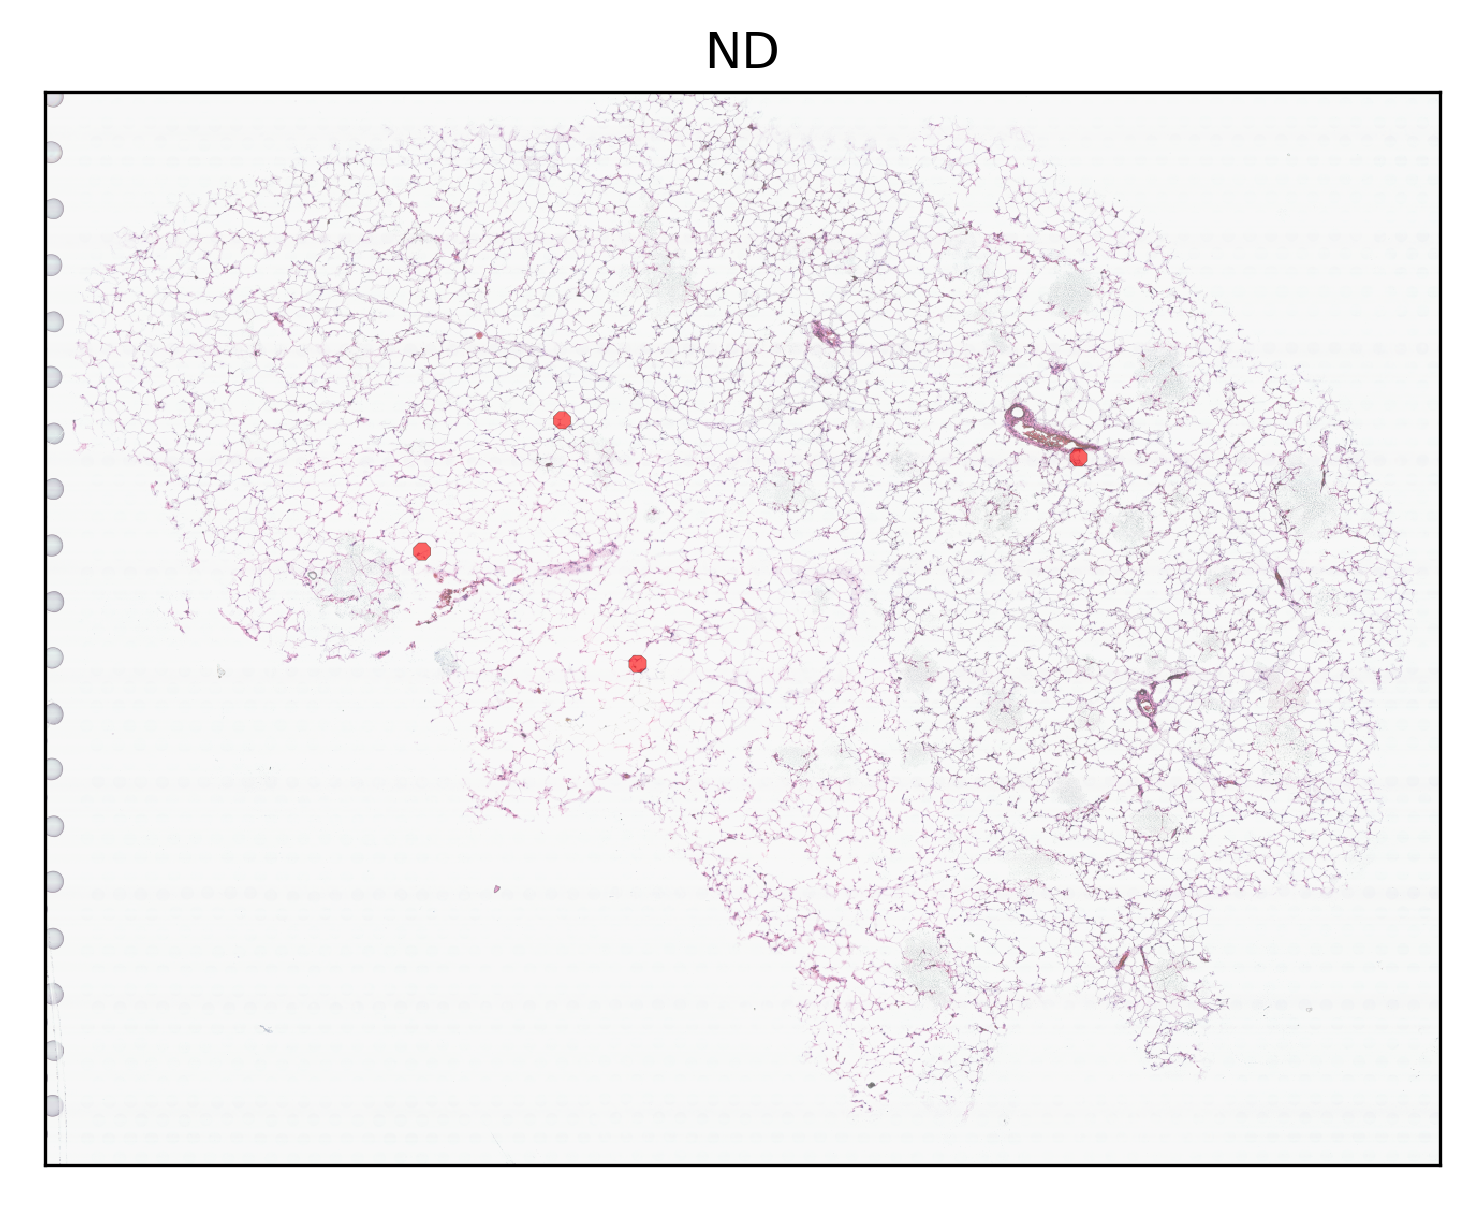

HFD8
(3392, 31053)
0.04805424528301887


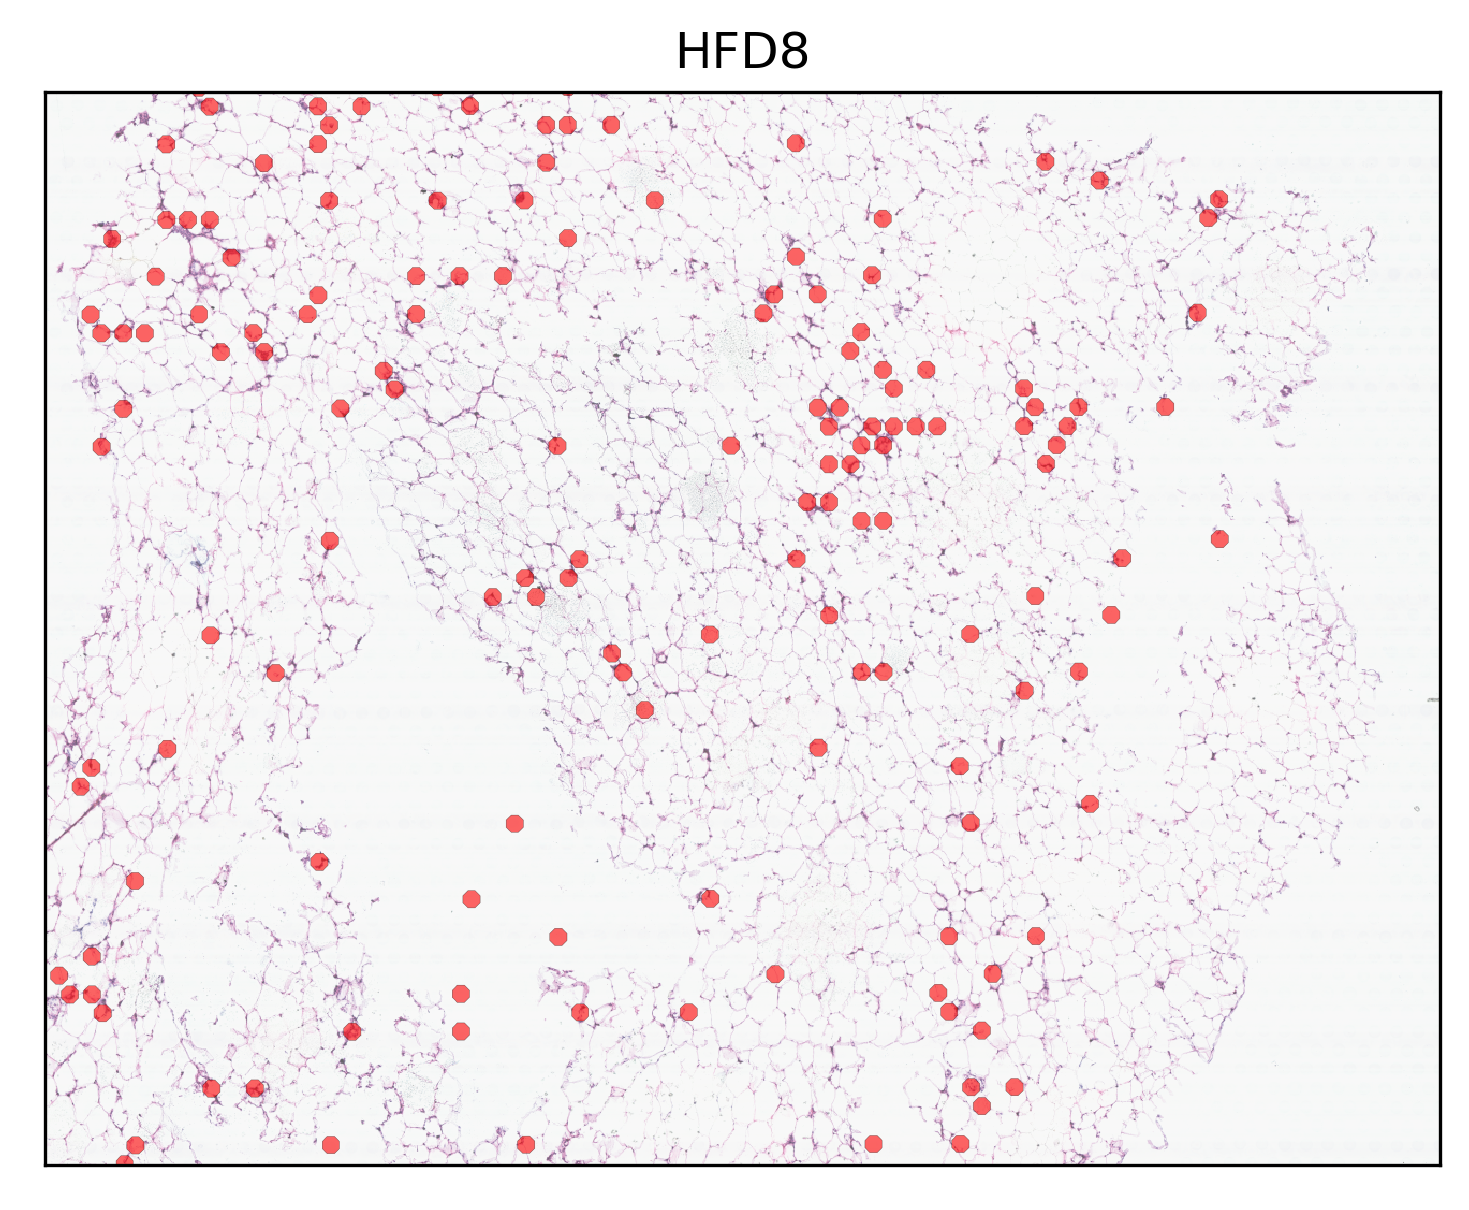

HFD14
(1994, 31053)
0.1424272818455366


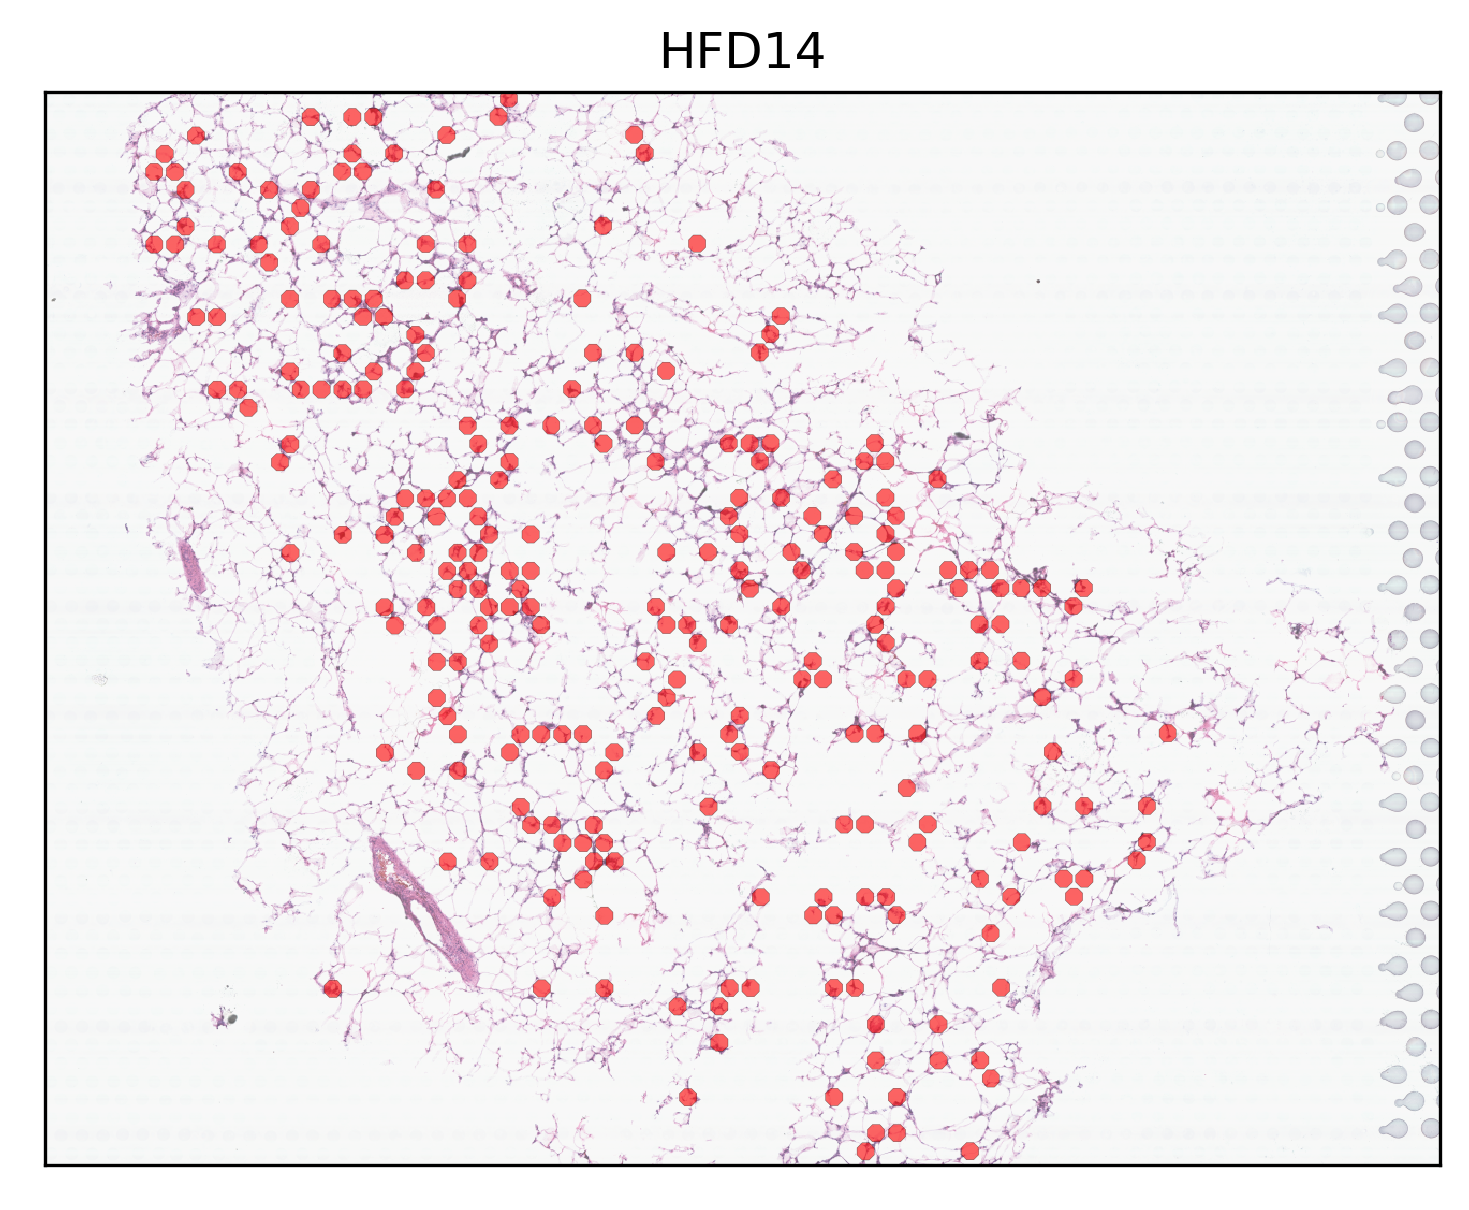

In [18]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'


def getImage(data):
    """A function to get image from the spatial data """
    from scanpy.pl._tools import scatterplots as spt    
    sptData = data.uns['spatial']
    
    libraryId = list(sptData.keys())[0]
    sptData = sptData[libraryId]
    
    # get params
    img = sptData['images']['hires']
    scale_factor = sptData['scalefactors']['tissue_hires_scalef']
    return img, scale_factor

alpha = 0.6
thresh = 0

pairs = [
('TREM2', 'SEMA6D'),
('SEMA6D', 'TREM2'),
]


plotAll = False # if False, plots both individually

for key in keys:
    print(key)
    data = adata[key]

    # get the image and the scale factors
    img, scale_factor = getImage(data)
    
    # get the data
    df = data.to_df()
    
    # get the image coordinates and scale them
    coords = data.obsm['spatial']
    x = coords[:, 0]
    y = coords[:, 1]
    x = x * scale_factor 
    y = y * scale_factor 
    
    print(df.shape)
    spotOn = np.zeros((df.shape[0]))
    
    for p1, p2 in pairs:
        meanP1 = df[p1]
        # meanP2 = df[p2]
        
        mask = (meanP1 > thresh) & (meanP2 > thresh)
        spotOn[mask] = 1
    
    mask = (spotOn == 1)
    
    print(np.sum(mask) / len(mask))
    x = x[mask]
    y = y[mask]
    color = ['r'] * np.sum(mask)
    
    plt.scatter(x, 
                y,
                c=color,
                marker="8",
                edgecolor="k",
                lw=0.1,
                zorder=2,
                alpha=alpha,
                s=20)

        
    # plot the plate
    plt.imshow(img.astype(float), 
               interpolation='none',
               cmap='binary',
               alpha=0.7,
               zorder=1)
    
    # plt.legend()
    
    ax = plt.gca()
    ax.set_xlim(200, 1500)
    ax.set_ylim(1650, 650)
    ax.set_aspect("equal")
    ax.set_title(key)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()